# Clustering data

Plan:

- Import data
- Explore data
    - Do something with the data, that has strange/uncovertable type
- Scale data
- Lower the dimentionality
- DBSCAN
    - Why DBSCAN?
    - Estimate epsilon
    - Estimate minPts
    - Run

## Import & explore data

In [1]:
import pandas as pd
import os


# Load all data from the path to dataframe
def load_files_to_df(path):
    result_df = pd.DataFrame()

    for file in os.listdir(path):
        df = pd.read_csv(f'{path}\\{file}', header=None)
        df[2] = df[2].astype(str)
        result_df = result_df.append(df)

    return result_df.reset_index(drop=True)

df = load_files_to_df('.\\Demo')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59510 entries, 0 to 59509
Data columns (total 3 columns):
0    59510 non-null int64
1    59510 non-null int64
2    59510 non-null object
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


As we see, the data in the column 2 cannot be converted directly to float or int, so we need to check, what values are in there.

In [4]:
import numpy as np


np.unique(df.iloc[:,2])

array(['1', '13', '17', '19', '2', '23', '24--4111', '24-15', '24-4',
       '24-5', '24-51', '24-52', '24-53', '24-57', '24-58', '24-59', '25',
       '5', '9'], dtype=object)

We see that some data in the column is strange, but how many samples are there?

In [5]:
strange_data = ['24--4111', '24-15', '24-4', '24-5', '24-51', '24-52', '24-53', '24-57', '24-58', '24-59']
strange_data_filter = map(lambda lbl: df[df.iloc[:,2] == lbl].shape[0], strange_data)
sum(list(strange_data_filter))

813

Because the amount is not big: 813/60000, we may drop it or unify data somehow.

Here we will asume, that every point in the column with 24 in its label is just 24.

In [22]:
for lbl in strange_data:
    df[df.iloc[:,2] == lbl] = '24'
    
sec_column_lbl = df.iloc[:,2]

### Utility

In [8]:
# Plot clusters and noise
def cluster_plot(X_dat, y_dat, x_coord=0, y_coord=1, 
                 labels=[], cen_x=[], cen_y=[], leg=True, 
                 noise=False, noise_i=-1, n_clust=0, seed=0):
    # Validate input data
    assert n_clust >= 0
    # Seed for data replication
    np.random.seed(seed)
    # Find number of clusters if not specified
    if n_clust == 0:
        denoise_lst = list(filter(lambda y: y >= 0, y_dat))
        n_clust = len(np.unique(denoise_lst))
    # normalize color, so each one represents from 30 to 230 RGB intensity
    # and its values lie between 30/255 to 230/255
    # this way the colors would not look very dark or light
    color = np.random.rand(n_clust,3)
    color = 30/255 + color*200/255
    for i in range(n_clust):
        # Name clusters if their labels specified
        if any(labels):
            label = labels[i]
        else:
            label = f'Cluster {i+1}'
        plt.scatter(X_dat[y_dat==i,x_coord],
                       X_dat[y_dat==i,y_coord],
                       s=1,
                       c=color[i],
                       marker='o',
                       label=label)
    # Plot centroids
    if any(cen_x):
        assert len(cen_x) == len(cen_y)
        plt.scatter(cen_x,
                   cen_y,
                   s=1,
                   marker='*',
                   c='orangered',
                   label='Centroid')
    # Plot noise
    if noise:
        plt.scatter(X_dat[y_dat == noise_i, x_coord], 
                    X_dat[y_dat == noise_i, y_coord],
                    c='lightgray', marker='o', s=1,
                    label='Noise')
    if leg:
        plt.legend()
    plt.tight_layout()
    plt.show()

## Prepare and visualize data

To prepare data we will use Standard Scaler.

In [54]:
from sklearn.preprocessing import StandardScaler


df_scaler = StandardScaler()
df_scaler.fit(df.values)
df_scaled = df_scaler.transform(df.values)

C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Now we will visualize the appearence of the data in 3d plot

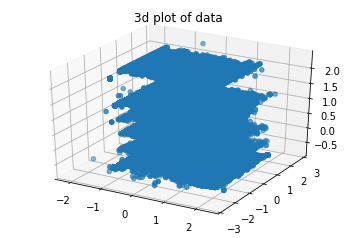

In [55]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3d plot of data')
ax.scatter(df_scaled[:,0], df_scaled[:,1], df_scaled[:,2])

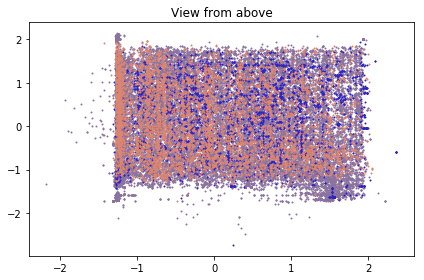

In [26]:
sec_column_values = sec_column_lbl.values.astype(int)

plt.title('View from above')
cluster_plot(df_scaled[:,:2], sec_column_values, leg=False)

## PCA

We will use PCA here to get lower dimension data. Because the 2nd column data is not very variative hence, it does not contain much information.

In [49]:
from sklearn.decomposition import PCA


# Lower dimensionality from 3 to 2d
pca = PCA(n_components=2)
df_scaled_pca = pca.fit_transform(df_scaled)

## DBSCAN 

# Why DBSCAN?

The task is: cluster the 3d dataset with **non-hierarchical** clustering algorithm. The number of clusters is **dynamical**.

For this task I use DBSCAN. DBSCAN is a pretty fast algorithm for clustering. It has complexity of *O(n)*, making it efficient either. 

It solves the problem of finding clusters in *dense data*. Also it solves the task of *finding number of clusters* by itself. Finally, in the input data there obviously are many outliers - noises. The algorithm marks such points as *noise*. 

Advantages of DBSCAN:

- **Dynamically** finds cluster number and size, no need to find the number by hand
- **Noise** detection
- **Speed** and linear **complexity**
- Finds clusters in **dense and sparse** data
- **Non-hierarchical**

Disadvantages:

- Needs two parameters to be found to work. But this task may be automated for every new dataset.

The only two parameters needed for the algorithm to work are *epsilon* and *number of neighbors*.


### Estimating epsilon

The epsilon is a radius around the point. If another point falls into sphere of radius = epsilon, the second point is marked as a neighbor. If number of neighbors around the point is over min_pts - another parameter - the cluster is created.   

To find the epsilon we firstly need to find minimal distance for every point between the point and other closest point. 

In [28]:
from scipy.spatial import distance_matrix


# For every point of data find distance to the closest point
def find_min_nonzero_dist(data_full, x):
    # Make every point the size of (1,2)
    dist_vect = distance_matrix(data_full, x.reshape(1,2))
    # Don't count if the distance is 0 - it may be the same point
    nonzero_elems = dist_vect[np.nonzero(dist_vect)]   
    
    return np.min(nonzero_elems)

min_dist = np.apply_along_axis(
            lambda x: find_min_nonzero_dist(df_scaled_pca, x), 
            axis=1, 
            arr=df_scaled_pca)

In [29]:
# Split data in n equal parts
# And count the sum of elements for every segment
def n_times_split(data, n):
    # Find borders for the whole segment
    min_val = np.min(data)
    max_val = np.max(data)
    ranges = np.linspace(min_val, max_val, n)
    # Append the upper limit but a little bit bigger
    # So that (bottom_lim <= x < upper_lim) works for the biggest value
    ranges = np.append(ranges, max_val+0.0001)
    result = np.zeros(n)
    ranges_lbl = list()
    # Generate ranges labels
    for i in range(ranges.shape[0]-1):
        ranges_lbl.append(f'{ranges[i]:.4f} - {ranges[i+1]:.4f}')
    # Count number of occurences for every segment
    for x in data:
        for i in range(ranges.shape[0]-1):
            bottom_lim = ranges[i]
            upper_lim = ranges[i+1]
            if bottom_lim <= x < upper_lim:
                result[i] += 1
                break
                
    return result, ranges_lbl
    
n_splits = 400
categorical_split, ranges_lbl = n_times_split(min_dist, n_splits)

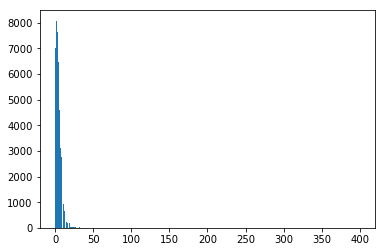

In [30]:
plt.bar(range(n_splits), categorical_split)
plt.show()

As we see, the biggest amount of occurences is under number of 30.

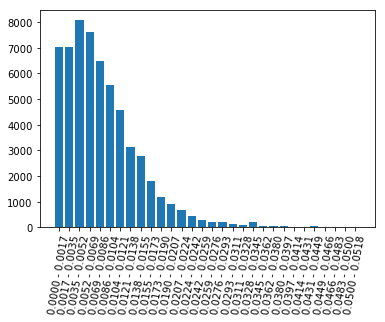

In [31]:
zoom = 30
plt.bar(range(zoom), categorical_split[:zoom])
plt.xticks(range(zoom), ranges_lbl[:zoom], rotation=80)
plt.show()

We see, that the most occurences lies in a range under 0.0224. Let's take this number as epsilon.

In [32]:
epsilon = 0.0224

### Find n neighbors

To find appropiate number of neighbors we should count the average number of neighbors, that falls into distance = epsilon to every point of data. 

In [33]:
# Find number of closest neighbors around every point of data, 
# that falls into a sphere of radius = dist
def number_of_point_within_distance(data, dist):
    result = np.array([])
    for x in data:
        dist_vect = distance_matrix(data, x.reshape(1,2))
        filtered_elems = dist_vect[dist_vect <= dist]
        # -1 because the point has zero distance to itsels, don't count it 
        count = filtered_elems.shape[0] - 1 
        result = np.append(result, count) 
    return result
    
num_points = number_of_point_within_distance(df_scaled_pca, epsilon)

Let's build the histogram to see, how the number of neighbors within the distance is distributed.

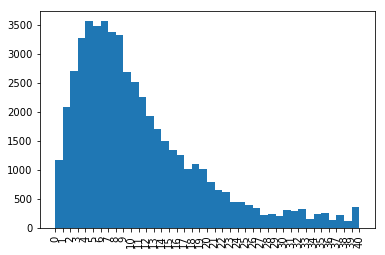

In [34]:
_, lims, _ = plt.hist(num_points, bins=40, range=(0,40))
plt.xticks(range(lims.shape[0]), lims.astype(int), rotation=90)
plt.show()

We may see, that average maximum is below 5, so let's take this number as the number of neighbors.

In [64]:
min_pts = 5

### Run DBSCAN

In [65]:
from sklearn.cluster import DBSCAN


sample_df = df_scaled_pca
dbscan = DBSCAN(eps=epsilon, min_samples=min_pts)
pred = dbscan.fit_predict(sample_df)

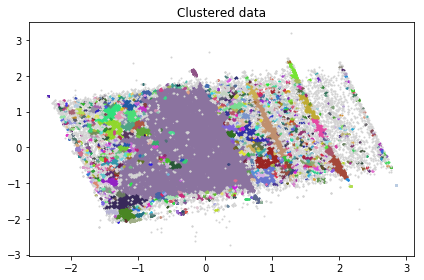

In [66]:
plt.title('Clustered data')
cluster_plot(sample_df, pred, leg=False, noise=True)

In [67]:
num_noise_points = (pred[pred<0]).shape[0]
num_all_points = sample_df.shape[0]
num_clusters = np.unique(pred).shape[0] - 1 # Minus noise
print(f'{(num_noise_points/num_all_points)*100:.2f}% of noise points.')
print(f'{num_clusters} clusters')

8.59% of noise points.
915 clusters


**We see, that the algorithm has marked 8.59% of points as noise. And it found 915 clusters for given parameters.**

## Comapre DBSCAN to KMeans

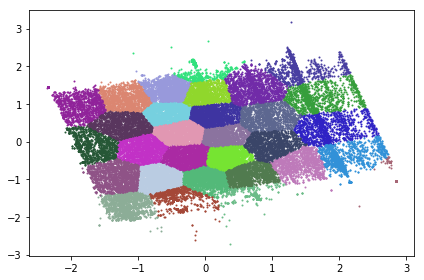

In [48]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=30)
km_pred = kmeans.fit_predict(sample_df)

cluster_plot(sample_df, km_pred, leg=False)

As we see, the K-Means not only generalize worse on the dense data, it also works **much slower**. 

Also for K-Means it is necessary to find **number of clusters** firstly, which is not suitable for our task with *dynamic number of clusters*.